## pix2pix(U-Net + GAN) experiments

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.WARN)

### Model definitions

In [2]:
from utils import load_dataset, save_p2p_models, load_p2p_models
from utils import plot_p2p_models, plot_p2p_losses, gen_nn_output
from utils import three_image_generators
from models import g_unet, discriminator, pix2pix
from train import train

Using TensorFlow backend.


### Dataset loading + preprocessing

In [3]:
W = 256
H = 256
dataset_path = '../data/sand'
trend_num = 3
side1_train, side2_train, panorama_train, side1_val, side2_val, panorama_val, N_train, N_val = load_dataset(
    dataset_path, trend_num=trend_num, mode=3, W=W, H=H)

Validation dataset: 100%|██████████| 175/175 [00:00<00:00, 325.00it/s]


In [4]:
batch_size = 130
train_gen, val_gen = three_image_generators(
    side1_train, side2_train, panorama_train, side1_val, side2_val, panorama_val, batch_size=batch_size)

### Training

In [5]:
models_path = 'trained_models/sand'
trend_num = 3
nn_name = 'nf16_3x3_woUnet'

In [6]:
# создание моделей
nf = 16
f_gen = g_unet(nf)
d = discriminator(nf)
p2p = pix2pix(f_gen, d)
plot_p2p_models(models_path, trend_num, nn_name, f_gen, d, p2p)
#tbCallback = create_tb_callback(models_path, trend_num, nn_name)

Dir already exist


In [ ]:
# обучение
losses = train(f_gen, d, p2p, train_gen, val_gen, epochs=2,
               train_samples=N_train, val_samples=N_val, batch_size=batch_size)
save_p2p_models(models_path, trend_num, nn_name, f_gen, d, losses)

Epoch 1/1
 1/26 [>.............................] - ETA: 249s - loss: 0.6993

### Trained NN

In [52]:
f_gen, d, losses = load_p2p_models(models_path, trend_num, nn_name)
p2p = pix2pix(f_gen, d)

Dir already exist


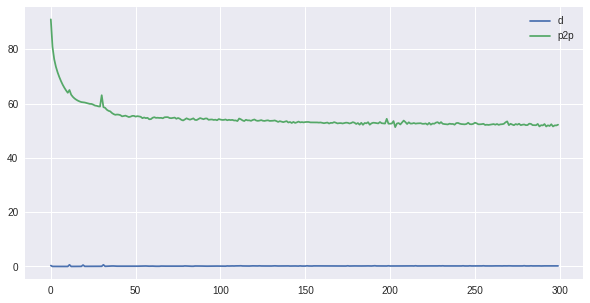

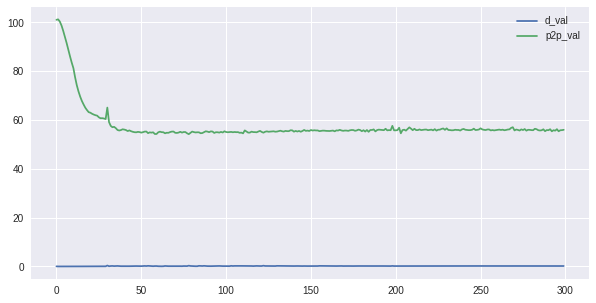

In [20]:
plot_p2p_losses(models_path, trend_num, nn_name, losses)

In [21]:
s1, s2, pan, gen = gen_nn_output(models_path, trend_num, nn_name, f_gen, val_gen, 10, W, H)

Dir already exist
NN output saved successfully.


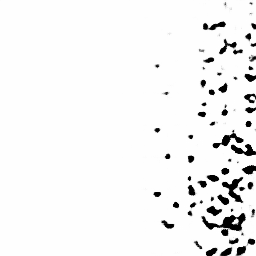

In [22]:
gen[2]

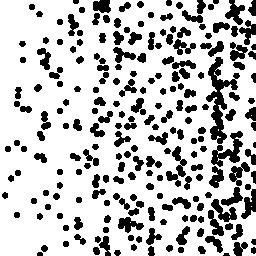

In [15]:
pan[2]

### Metrics 

In [1]:
from utils import tr_mse_fit, tr_mse

Using TensorFlow backend.


In [3]:
train_mse, val_mse, tmse, vmse = tr_mse_fit('../data/sand', 3, 3)

Train dataset:   0%|          | 0/3325 [00:00<?, ?it/s]

Found 3325 train samples
Found 175 validation samples


Validation dataset: 100%|██████████| 175/175 [00:16<00:00, 10.66it/s]


In [4]:
train_mse

189.84781939395941

In [5]:
val_mse

189.29219013033958

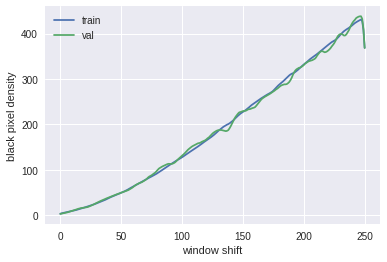

In [9]:
plt.plot(tmse, label='train')
plt.plot(vmse, label='val')
plt.xlabel('window shift')
plt.ylabel('black pixel density')
plt.legend()
plt.savefig('../data/sand/trend3/metrics/tr_mse.png')

In [10]:
np.save('../data/sand/trend3/metrics/tmse.npy', tmse)
np.save('../data/sand/trend3/metrics/vmse.npy', vmse)

In [12]:
from PIL import Image
image = Image.open('trained_models/sand/trend2/nf16_3x3_woUnet/nn_output/sample2.jpg')

In [14]:
err, err_shift = tr_mse(image, tmse, 3)

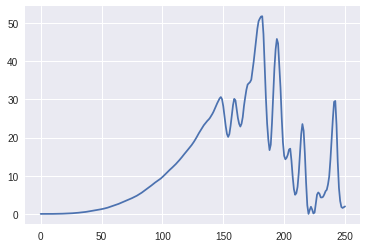

In [16]:
plt.plot(err_shift)

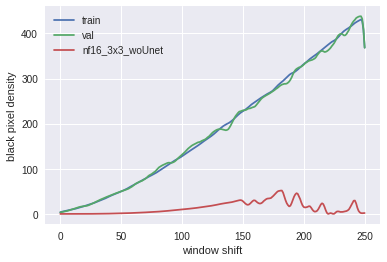

In [17]:
plt.plot(tmse, label='train')
plt.plot(vmse, label='val')
plt.plot(err_shift, label='nf16_3x3_woUnet')
plt.xlabel('window shift')
plt.ylabel('black pixel density')
plt.legend()
plt.savefig('trained_models/sand/trend2/nf16_3x3_woUnet/tr_mse.png')